# iCAT Overlay
---

#### Packages

In [1]:
from pathlib import Path
from itertools import product
from pprint import pprint

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import altair as alt

from shapely.geometry import box
from shapely import affinity
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

import renderapi
from renderapi.tilespec import TileSpec
from renderapi.transform import AffineModel as AffineRender

from icatapi.render_pandas import *
from icatapi.overlay import *

#### Settings

In [2]:
# pandas display settings
# -----------------------
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 20)

## Set up `render-ws` environment
---

In [4]:
# `render` project parameters
# ---------------------------
owner = 'rlane'
project = '20191230_RL010'

# Create a renderapi.connect.Render object
# ----------------------------------------
render_connect_params = {
    'host': 'sonic',
    'port': 8080,
    'owner': owner,
    'project': project,
    'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
    'memGB': '2G'
}
render = renderapi.connect(**render_connect_params)

# Infer stack and section info
# ----------------------------
stacks = renderapi.render.get_stacks_by_owner_project(render=render)
stacks_EM = [stack for stack in stacks if 'EM' in stack]
stacks_FM = [stack for stack in stacks if 'EM' not in stack]
stacks_2_overlay = {
    'over': stacks_FM,
    'undr': 'big_EM',
}

# Output
# ------
out = f"""\
all stacks.......... {stacks}
EM stacks........... {stacks_EM}
FM stacks........... {stacks_FM}
stacks to overlay... {stacks_2_overlay}
...
"""
print(out)

# Create stacks DataFrame
# ------------------------
df_project = create_stacks_DataFrame(stacks=stacks_2_overlay['over'] +\
                                           [stacks_2_overlay['undr']],
                                     render=render)
df_project.groupby('stack')\
          .apply(lambda x: x.sample(3))\
          .drop(['camera', 'temca'], axis=1)

all stacks.......... ['lil_EM_montaged', 'lil_EM', 'insulin', 'hoechst', 'big_EM']
EM stacks........... ['lil_EM_montaged', 'lil_EM', 'big_EM']
FM stacks........... ['insulin', 'hoechst']
stacks to overlay... {'over': ['insulin', 'hoechst'], 'undr': 'big_EM'}
...



tileId    z   width  height  minIntensity  \
stack                                                                 
big_EM  238  aak_big_EM-S002-...  2.0  4096.0  4096.0       31900.0   
        240  aaa_big_EM-S003-...  3.0  4096.0  4096.0       31900.0   
        243  aad_big_EM-S003-...  3.0  4096.0  4096.0       31900.0   
hoechst 144  aaa_hoechst-S004...  4.0  2048.0  2048.0         655.0   
        214  aak_hoechst-S009...  9.0  2048.0  2048.0         655.0   
        151  aah_hoechst-S004...  4.0  2048.0  2048.0         655.0   
insulin 66   aag_insulin-S006...  6.0  2048.0  2048.0         570.0   
        47   aal_insulin-S004...  4.0  2048.0  2048.0         570.0   
        39   aad_insulin-S004...  4.0  2048.0  2048.0         570.0   

             maxIntensity    stack sectionId  imageRow  imageCol       stageX  \
stack                                                                           
big_EM  238       33450.0   big_EM      S002         0         1  -174.000000   
        240       33450.0   big_EM      S003         3         0   225.555000   
        243       33450.0   big_EM      S003         2         2   606.492000   
hoechst 144        1800.0  hoechst      S004         3         0   835.660023   
        214        1800.0  hoechst      S009         0         1  4021.954973   
        151        1800.0  hoechst      S004         1         1  1025.598744   
insulin 66          740.0  insulin      S006         1         0  2037.222002   
        47          740.0  insulin      S004         0         0   834.604182   
        39          740.0  insulin      S004         2         2  1216.568437   

                  stageY             imageUrl           transforms  
stack                                                               
big_EM  238  6510.065000  file:///long_ter...  [M=[[1.000000,0....  
        240  5951.659000  file:///long_ter...  [M=[[1.000000,0....  
        243  6146.166000  file:///long_ter...  [M=[[1.000000,0....  
hoechst 144  5981.682534  file:///long_ter...  [M=[[1.000000,0....  
        214  6557.011148  file:///long_ter...  [M=[[1.000000,0....  
        151  6371.521975  file:///long_ter...  [M=[[1.000000,0....  
insulin 66   6381.338217  file:///long_ter...  [M=[[1.000000,0....  
        47   6566.334089  file:///long_ter...  [M=[[1.000000,0....  
        39   6176.607705  file:///long_ter...  [M=[[1.000000,0....

## Compute overlay transforms
---

### Sample overlay transform

In [5]:
# Choose random FM image tile filepath
fp = Path(df_project.loc[df_project['stack'].isin(stacks_2_overlay['over'] +\
                                                 [stacks_2_overlay['undr']])]\
                    .sample(1)['imageUrl']\
                    .str.split('://')\
                    .iloc[0][1])

# Test parser
(psx, psy), ro, sh, (trx, try_) = get_transform_metadata(fp)

# Output
out = f"""\
File.......... {fp.parent.name}/{fp.name}
Pixel size.... ({1e9*psx:.1f}nm, {1e9*psy:.1f}nm)
Rotation...... {np.rad2deg(ro):.1f}°
Shear......... {sh:.2e}
Translation... ({1e6*trx:.1f}um, {1e6*try_:.1f}um)
"""
print(out)

File.......... hoechst/hoechst-00000x00003.tif
Pixel size.... (106.4nm, 106.4nm)
Rotation...... 353.1°
Shear......... 1.39e-17
Translation... (2641.9um, 5991.0um)



### Compile transform data

In [7]:
# Create multiindex
overlay_cols = ['stack', 'z', 'sectionId',
                'tileId', 'imageRow', 'imageCol',
                'width', 'height',
                'imageUrl', 'transforms',
                'ps', 'ro', 'sh', 'tr',
                'overlay_transforms']
multiindex = np.array(list(product(overlay_cols,
                                   ['EM', 'FM']))).T.tolist()
# Initialize overlay DataFrame
df_overlay = pd.DataFrame(columns=multiindex)

# Loop through overlay stacks
for stack in stacks_2_overlay['over']:
    # Filter to stack DataFrame
    df_stack = df_project.loc[(df_project['stack'] == stack)].copy()

    # Loop through FM tiles
    for i, FM_tile in df_stack.iterrows():

        # Find correlative EM tile
        EM_tile = df_project.loc[(df_project['stack'] == stacks_2_overlay['undr']) &\
                                 (df_project['z'] == FM_tile['z']) &\
                                 (df_project['imageRow'] == FM_tile['imageRow']) &\
                                 (df_project['imageCol'] == FM_tile['imageCol'])].iloc[0]

        # Parse tif for transform metadata
        fp_EM = Path(EM_tile['imageUrl'].split('://')[1])
        fp_FM = Path(FM_tile['imageUrl'].split('://')[1])
        ps_EM, ro_EM, sh_EM, tr_EM = get_transform_metadata(fp_EM)
        ps_FM, ro_FM, sh_FM, tr_FM = get_transform_metadata(fp_FM)

        # Build up overlay DataFrame one FM tile at a time
        df_overlay.loc[i, 'stack'] = EM_tile['stack'], FM_tile['stack']
        df_overlay.loc[i, 'z'] = EM_tile['z'], FM_tile['z']
        df_overlay.loc[i, 'sectionId'] = EM_tile['sectionId'], FM_tile['sectionId']
        df_overlay.loc[i, 'tileId'] = EM_tile['tileId'], FM_tile['tileId']
        df_overlay.loc[i, 'imageRow'] = EM_tile['imageRow'], FM_tile['imageRow']
        df_overlay.loc[i, 'imageCol'] = EM_tile['imageCol'], FM_tile['imageCol']
        df_overlay.loc[i, 'width'] = EM_tile['width'], FM_tile['width']
        df_overlay.loc[i, 'height'] = EM_tile['height'], FM_tile['height']
        df_overlay.loc[i, 'imageUrl'] = EM_tile['imageUrl'], FM_tile['imageUrl']
        df_overlay.loc[i, 'transforms'] = [EM_tile['transforms']], [FM_tile['transforms']]
        # Transform metadata
        df_overlay.loc[i, 'ps'] = ps_EM, ps_FM
        df_overlay.loc[i, 'ro'] = ro_EM, ro_FM
        df_overlay.loc[i, 'sh'] = sh_EM, sh_FM
        df_overlay.loc[i, 'tr'] = tr_EM, tr_FM

# Unpack nested transforms
df_overlay[('transforms', 'EM')] = df_overlay[('transforms', 'EM')].apply(lambda x: x[0])
df_overlay[('transforms', 'FM')] = df_overlay[('transforms', 'FM')].apply(lambda x: x[0])

# Preview tile data
pd.set_option('display.max_colwidth', 15)
df_overlay.groupby(('stack', 'FM'))\
          .apply(lambda x: x.sample(4))\
          .drop(['ps', 'ro', 'sh', 'tr',
                 'overlay_transforms'], level=0, axis=1)

stack             z      sectionId                tileId  \
                     EM       FM   EM   FM        EM    FM              EM   
(stack, FM)                                                                  
hoechst     141  big_EM  hoechst  3.0  3.0      S003  S003  aaj_big_EM-...   
            170  big_EM  hoechst  6.0  6.0      S006  S006  aac_big_EM-...   
            144  big_EM  hoechst  4.0  4.0      S004  S004  aaa_big_EM-...   
            134  big_EM  hoechst  3.0  3.0      S003  S003  aac_big_EM-...   
insulin     39   big_EM  insulin  4.0  4.0      S004  S004  aad_big_EM-...   
            20   big_EM  insulin  2.0  2.0      S002  S002  aai_big_EM-...   
            83   big_EM  insulin  7.0  7.0      S007  S007  aal_big_EM-...   
            16   big_EM  insulin  2.0  2.0      S002  S002  aae_big_EM-...   

                                imageRow      imageCol        width          \
                             FM       EM   FM       EM   FM      EM      FM   
(stack, FM)                                                                   
hoechst     141  aaj_hoechst...      0.0  0.0      2.0  2.0  4096.0  2048.0   
            170  aac_hoechst...      3.0  3.0      2.0  2.0  4096.0  2048.0   
            144  aaa_hoechst...      3.0  3.0      0.0  0.0  4096.0  2048.0   
            134  aac_hoechst...      3.0  3.0      2.0  2.0  4096.0  2048.0   
insulin     39   aad_insulin...      2.0  2.0      2.0  2.0  4096.0  2048.0   
            20   aai_insulin...      1.0  1.0      2.0  2.0  4096.0  2048.0   
            83   aal_insulin...      0.0  0.0      0.0  0.0  4096.0  2048.0   
            16   aae_insulin...      2.0  2.0      1.0  1.0  4096.0  2048.0   

                 height                imageUrl                  \
                     EM      FM              EM              FM   
(stack, FM)                                                       
hoechst     141  4096.0  2048.0  file:///lon...  file:///lon...   
            170  4096.0  2048.0  file:///lon...  file:///lon...   
            144  4096.0  2048.0  file:///lon...  file:///lon...   
            134  4096.0  2048.0  file:///lon...  file:///lon...   
insulin     39   4096.0  2048.0  file:///lon...  file:///lon...   
            20   4096.0  2048.0  file:///lon...  file:///lon...   
            83   4096.0  2048.0  file:///lon...  file:///lon...   
            16   4096.0  2048.0  file:///lon...  file:///lon...   

                     transforms                  
                             EM              FM  
(stack, FM)                                      
hoechst     141  [M=[[1.0000...  [M=[[1.0000...  
            170  [M=[[1.0000...  [M=[[1.0000...  
            144  [M=[[1.0000...  [M=[[1.0000...  
            134  [M=[[1.0000...  [M=[[1.0000...  
insulin     39   [M=[[1.0000...  [M=[[1.0000...  
            20   [M=[[1.0000...  [M=[[1.0000...  
            83   [M=[[1.0000...  [M=[[1.0000...  
            16   [M=[[1.0000...  [M=[[1.0000...

In [8]:
# Preview transform data
pd.set_option('display.max_colwidth', 15)
df_overlay.groupby(('stack', 'FM'))\
          .apply(lambda x: x.sample(4))\
          .drop(['tileId', 'width', 'height', 'imageUrl',
                 'transforms', 'overlay_transforms'], level=0, axis=1)

stack             z      sectionId       imageRow       \
                     EM       FM   EM   FM        EM    FM       EM   FM   
(stack, FM)                                                                
hoechst     161  big_EM  hoechst  5.0  5.0      S005  S005      2.0  2.0   
            132  big_EM  hoechst  3.0  3.0      S003  S003      3.0  3.0   
            181  big_EM  hoechst  7.0  7.0      S007  S007      3.0  3.0   
            210  big_EM  hoechst  9.0  9.0      S009  S009      1.0  1.0   
insulin     47   big_EM  insulin  4.0  4.0      S004  S004      0.0  0.0   
            38   big_EM  insulin  4.0  4.0      S004  S004      3.0  3.0   
            63   big_EM  insulin  6.0  6.0      S006  S006      2.0  2.0   
            42   big_EM  insulin  4.0  4.0      S004  S004      1.0  1.0   

                imageCol                   ps                   ro           \
                      EM   FM              EM              FM   EM       FM   
(stack, FM)                                                                   
hoechst     161      0.0  0.0  [3.39257365...  [3.32068982...  0.0  6.16378   
            132      0.0  0.0  [3.39227032...  [3.32099315...  0.0   6.1641   
            181      1.0  1.0  [3.39276508...  [3.32049839...  0.0  6.16343   
            210      0.0  0.0  [3.39241094...  [3.32085253...  0.0  6.16263   
insulin     47       0.0  0.0  [3.39195818...  [3.32130528...  0.0    6.164   
            38       2.0  2.0  [3.39252414...  [3.32073933...  0.0  6.16386   
            63       2.0  2.0  [3.39294923...  [3.32031423...  0.0  6.16359   
            42       0.0  0.0  [3.39209888...  [3.32116459...  0.0  6.16418   

                         sh                            tr                  
                         EM            FM              EM              FM  
(stack, FM)                                                                
hoechst     161  0.00690305 -1.387779e-17  [0.00143061...  [0.00618658...  
            132  0.00617385 -1.387779e-17  [0.00022555...  [0.00595165...  
            181  0.00727094 -1.387779e-17  [0.00283141...  [0.00599222...  
            210  0.00824168 -1.387779e-17  [0.00383112...  [0.00636159...  
insulin     47   0.00667178 -1.387779e-17  [0.00083065...  [0.00656554...  
            38   0.00669052  1.387779e-17  [0.00121159...  [0.00598199...  
            63   0.00701947 -1.387779e-17  [0.00241666...  [0.00618661...  
            42   0.00639136  1.387779e-17  [0.00083065...  [0.00637101...

### Compute overlay transforms

In [9]:
# Iterate through CLEM tiles
for i, tile in df_overlay.iterrows():

    # Initial translation derived from stage position
    T0_EM = tile[('transforms', 'EM')][-1]
    T0_FM = tile[('transforms', 'FM')][-1]

    # Overlay translation to center tiles
    C0_EM = AffineRender(B0=-tile[('width', 'EM')]/2,
                         B1=-tile[('height', 'EM')]/2)
    C0_FM = AffineRender(B0=-tile[('width', 'FM')]/2,
                         B1=-tile[('height', 'FM')]/2)

    # Compute relative transform
    A = AffineRender()
    A.M = compute_relative_transform(*np.array(tile['ps'].tolist()).T,
                                     *np.array(tile['ro'].tolist()),
                                     *np.array(tile['sh'].tolist()),
                                     *np.array(tile['tr'].tolist()).T)

    # Set overlay transforms
    df_overlay.loc[i, 'overlay_transforms'] = [C0_EM, T0_EM], [C0_FM, A, T0_EM]

# Preview sample overlay transform
sample = df_overlay.sample(1)
out = f"""\
{sample[('tileId', 'EM')].iloc[0]} | \
{sample[('tileId', 'FM')].iloc[0]}
"""
print(out)
sample['overlay_transforms'].values.tolist()

aaa_big_EM-S006-00000x00003 | aaa_hoechst-S006-00000x00003



[[[M=[[1.000000,0.000000],[0.000000,1.000000]] B=[-2048.000000,-2048.000000],
   M=[[1.000000,0.000000],[0.000000,1.000000]] B=[0.268126,17391.243529]],
  [M=[[1.000000,0.000000],[0.000000,1.000000]] B=[-1024.000000,-1024.000000],
   M=[[3.115021,-0.359775],[0.373466,3.184330]] B=[58.551791,-9.882417],
   M=[[1.000000,0.000000],[0.000000,1.000000]] B=[0.268126,17391.243529]]]]

## Upload overlaid stacks to `render-ws`
---

### Create overlaid stacks

In [10]:
# Collect overlay stacks
stacks_overlaid = []

# Iterate through stacks
for stack in tqdm(stacks_2_overlay['over'] +\
                 [stacks_2_overlay['undr']]):

    # Set overlay stack name
    stack_overlaid = f"{stack}_overlaid"
    stacks_overlaid.append(stack_overlaid)

    # Get stack DataFrame
    df_stack = df_project.loc[(df_project['stack'] == stack)].copy()
    df_stack.rename(columns={'minIntensity': 'minint',
                             'maxIntensity': 'maxint'}, inplace=True)

    # Create `TileSpec`s
    tile_specs = []
    for i, tile in df_stack.iterrows():

        # Get overlay transforms for each tile from overlay DataFrame
        k = 'FM' if stack in stacks_FM else 'EM' 
        tile['tforms'] = df_overlay.loc[(df_overlay[('stack', k)] == tile['stack']) &\
                                        (df_overlay[('z', k)] == tile['z']) &\
                                        (df_overlay[('imageRow', k)] == tile['imageRow']) &\
                                        (df_overlay[('imageCol', k)] == tile['imageCol']),
                                        ('overlay_transforms', k)].iloc[0]

        # Create `TileSpec
        ts = TileSpec(**tile.to_dict())
        tile_specs.append(ts)

    # Create stack
    renderapi.stack.create_stack(stack_overlaid,
                                 render=render)

    # Import TileSpecs to render
    renderapi.client.import_tilespecs(stack_overlaid,
                                      tile_specs,
                                      render=render)

    # Set stack state to complete
    renderapi.stack.set_stack_state(stack_overlaid,
                                    'COMPLETE',
                                    render=render)

## Inspect overlaid stacks
---

### Tile map

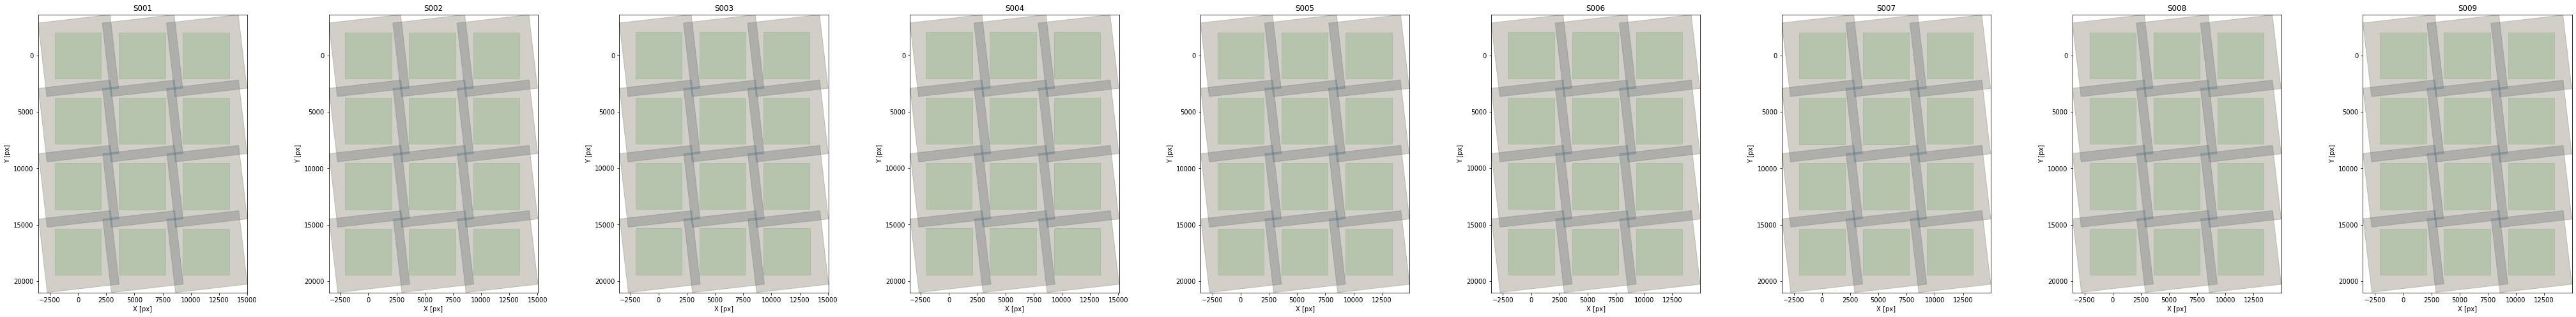

In [11]:
# Specify stacks and sections
stacks_2_plot = stacks_overlaid
sections_2_plot = df_project['sectionId'].unique().tolist()

# Set up figure
ncols = len(sections_2_plot)
fig, axes = plt.subplots(ncols=ncols, squeeze=False,
                         figsize=(8*ncols, 8))
axmap = {k: v for k, v in zip(sections_2_plot, axes.flat)}
cmap = {k: v for k, v in zip(stacks_2_plot, sns.color_palette(n_colors=len(stacks_2_plot)))}

# Iterate through layers
df_stacks = create_stacks_DataFrame(stacks_2_plot,
                                    render=render)
for sectionId, layer in tqdm(df_stacks.groupby('sectionId')):
    # Collect all tiles in each layer to determine bounds
    boxes = []
    # Set axis
    ax = axmap[sectionId]

    # Loop through tilesets within each layer
    for stack, tileset in layer.groupby('stack'):

        # Loop through each tile
        for i, tile in tileset.iterrows():

            # Create `shapely.box` resembling raw image tile
            b = box(0, 0, tile['width'], tile['height'])
            # Apply transforms to `shapely.box`
            for tform in tile['transforms']:
                A = (tform.M[:2, :2].ravel().tolist() +
                     tform.M[:2,  2].ravel().tolist())
                b = affinity.affine_transform(b, A)
            boxes.append(b)
            # Get coordinates of `shapely.box` to plot matplotlib polygon patch
            xy = np.array(b.exterior.xy).T
            p = Polygon(xy, color=cmap[stack], alpha=0.2)
            ax.add_patch(p)

    # Axis aesthetics
    ax.set_title(sectionId)
    ax.set_xlabel('X [px]')
    ax.set_ylabel('Y [px]')
    # Determine bounds
    bounds = np.swapaxes([b.exterior.xy for b in boxes], 1, 2).reshape(-1, 2)
    ax.set_xlim(bounds[:, 0].min(), bounds[:, 0].max())
    ax.set_ylim(bounds[:, 1].min(), bounds[:, 1].max())
    ax.invert_yaxis()
    ax.set_aspect('equal')

### Render images

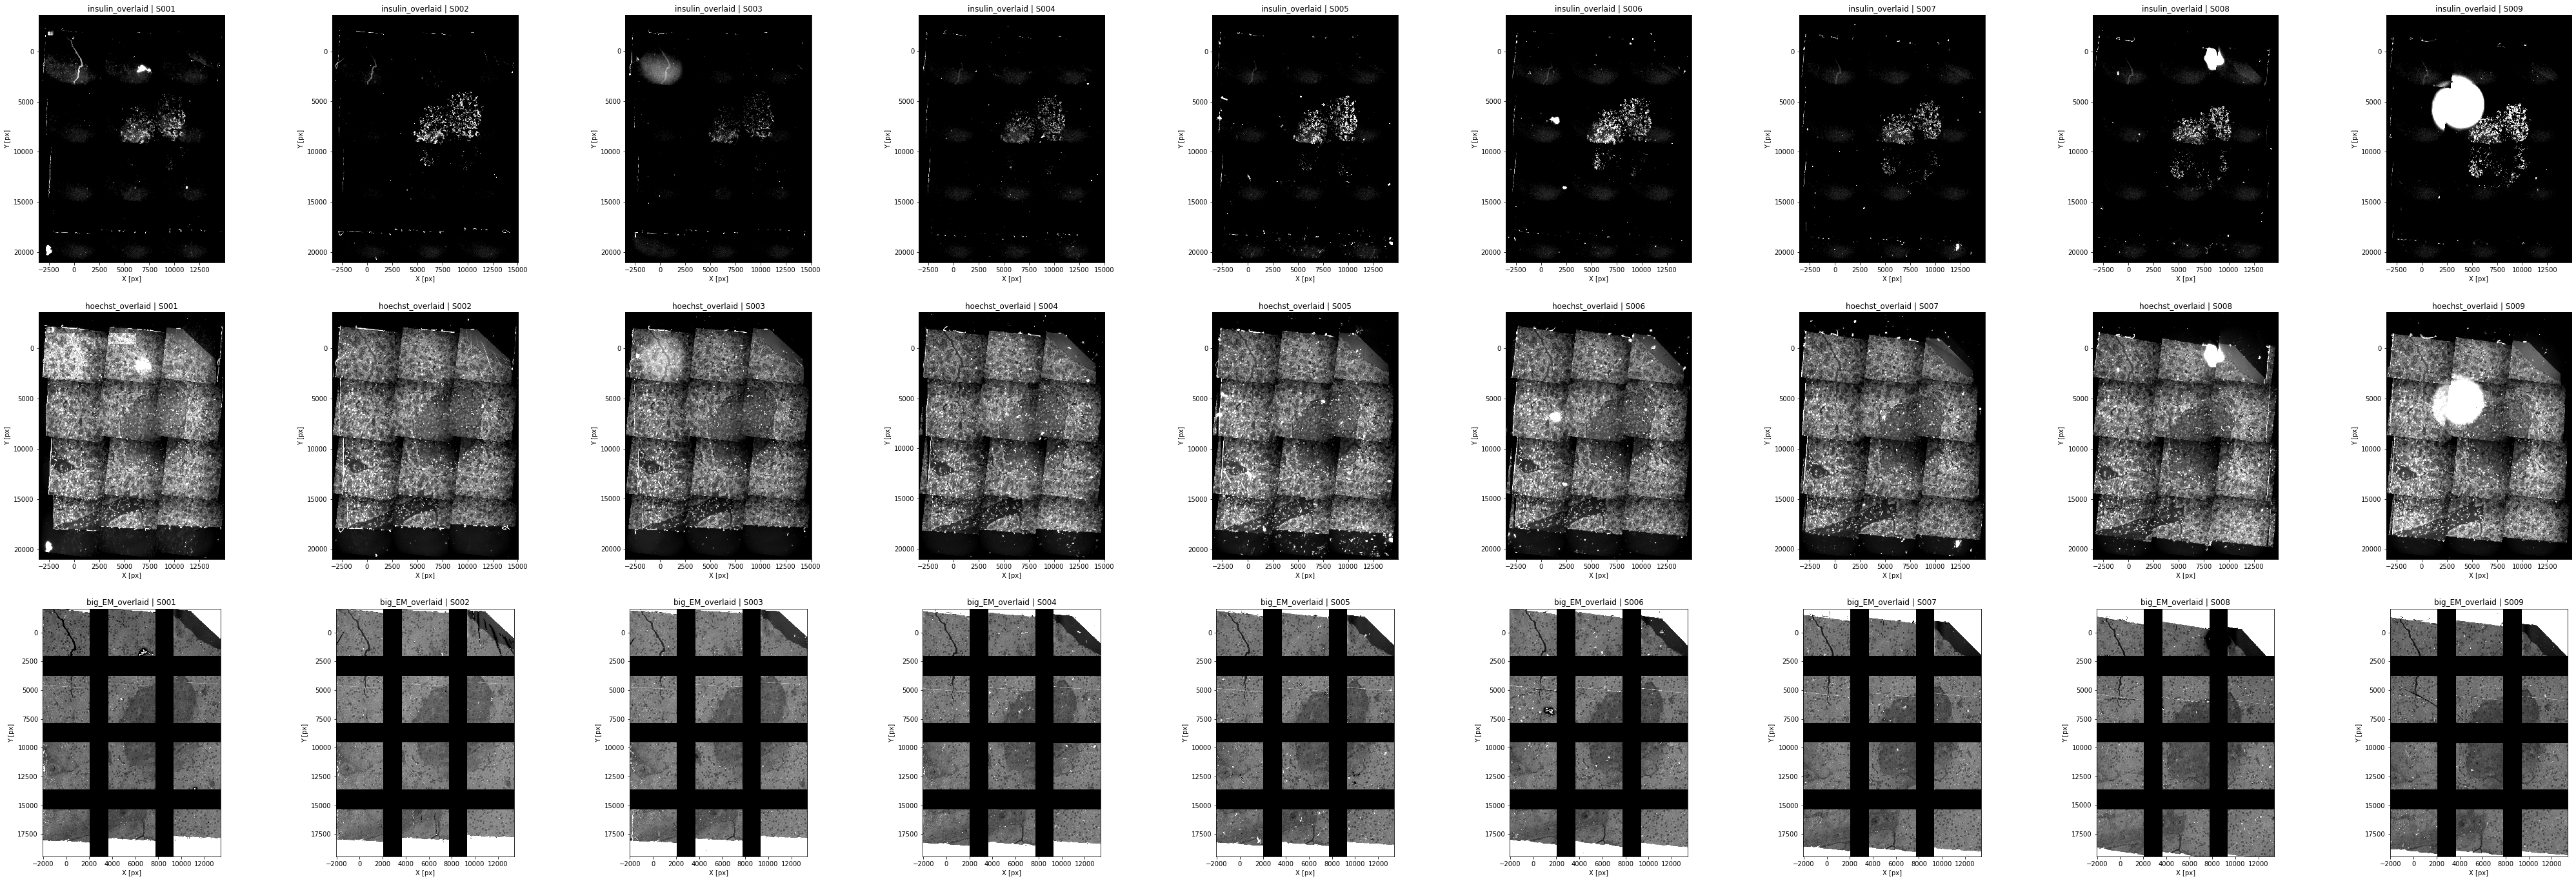

In [12]:
# Specify stacks and sections
stacks_2_plot = stacks_overlaid
sections_2_plot = df_project['sectionId'].unique().tolist()

# Set up figure
nrows = len(stacks_2_plot)
ncols = len(sections_2_plot)
fig, axes = plt.subplots(nrows, ncols, squeeze=False,
                         figsize=(8*ncols, 8*nrows))
axmap = {k: v for k, v in zip(product(stacks_2_plot, sections_2_plot), axes.flat)}
cmap = {k: v for k, v in zip(stacks_2_plot, sns.color_palette(n_colors=len(stacks_2_plot)))}

# Iterate through layers
df_stacks = create_stacks_DataFrame(stacks_2_plot,
                                    render=render)
for (stack, sectionId), tileset in tqdm(df_stacks.groupby(['stack', 'sectionId'])):

    # Set axis
    ax = axmap[(stack, sectionId)]
    # Fetch tileset image
    z = tileset['z'].iloc[0]
    bounds = renderapi.stack.get_bounds_from_z(stack=stack,
                                               z=z,
                                               render=render)
    scale = 1024 / np.max([bounds['maxX'] - bounds['minX'],
                           bounds['maxY'] - bounds['minY']])
    image = renderapi.image.get_section_image(stack=stack,
                                              z=z,
                                              scale=scale,
                                              maxTileSpecsToRender=30,
                                              render=render)
    # Plot
    extent = [bounds['minX'],  # left
              bounds['maxX'],  # right
              bounds['minY'],  # bottom
              bounds['maxY']]  # top
    ax.imshow(image, extent=extent, origin='lower')
    # Axis aesthetics
    ax.set_title(f"{stack} | {sectionId}")
    ax.set_xlabel('X [px]')
    ax.set_ylabel('Y [px]')
    ax.set_xlim()
    ax.invert_yaxis()